## Stacking with out of fold predictions


In [26]:
import utils
from utils import *
import xgboost as xgb
import seaborn as sns
%matplotlib inline

In [93]:
xgb_test_preds = load_array("data/results/xgb_5fold_s2019_test_preds_extrasvdv2.dat")
xgb_oof_preds = load_array("data/results/xgb_5fold_s2019_oof_preds_extrasvdv2.dat")

In [94]:
NN_test_preds = load_array("data/results/NN_5fold_s2019_test_preds_extrasvdv2.dat/")/5.0
NN_oof_preds = load_array("data/results/NN_5fold_s2019_oof_preds_extrasvdv2.dat/")

In [95]:
NN_val_scores = load_array("data/results/NN_val_scores.dat/")

In [96]:
# NN_val_scores

In [97]:
train_features = np.hstack((xgb_oof_preds,NN_oof_preds))
test_features=np.hstack((xgb_test_preds,NN_test_preds))

In [98]:
train_features.shape, test_features.shape

((404290, 2), (2345796, 2))

In [99]:
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))

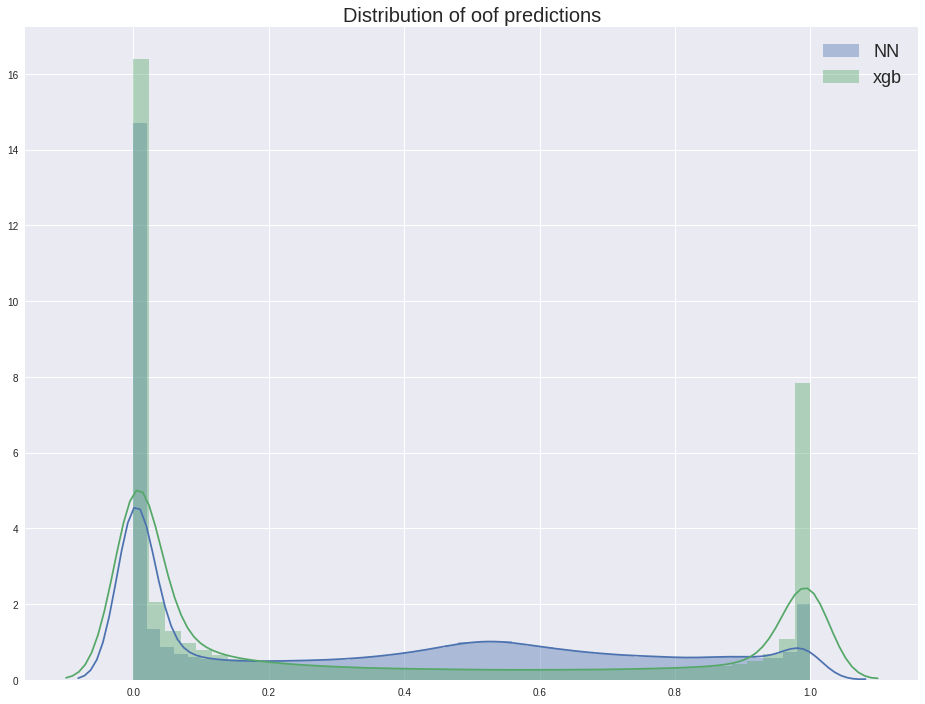

In [100]:
plt.rcParams['figure.figsize'] = 16, 12

sns.distplot(NN_oof_preds,label='NN',), sns.distplot(xgb_oof_preds,label='xgb')
plt.legend(loc='upper right', prop={'size': 18})
plt.title('Distribution of oof predictions', fontsize=20)

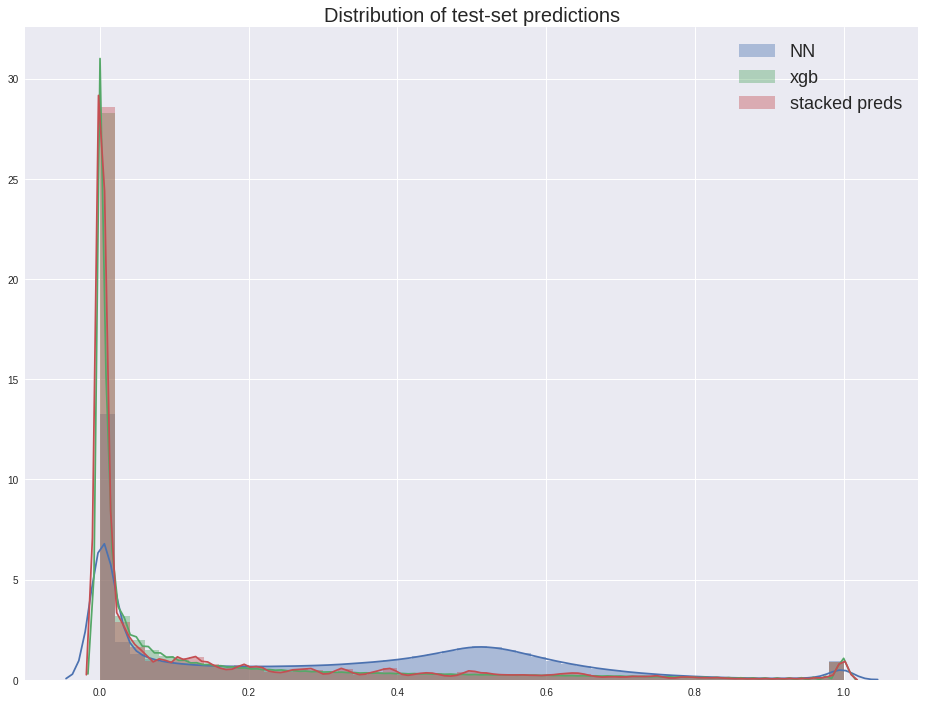

In [101]:
sns.distplot(NN_test_preds,label='NN'), sns.distplot(xgb_test_preds,label='xgb'), sns.distplot(preds_avg,label='stacked preds')
plt.legend(loc='upper right', prop={'size': 18})
plt.title('Distribution of test-set predictions', fontsize=20)

In [102]:
preds_avg.max(),xgb_test_preds.max(),NN_test_preds.max()

(0.99973267316818237, 0.99997787475585942, 1.0)

### Model

In [110]:
num_folds = 5
xgb_params = {'colsample_bylevel':1., # 0.9086627943049572,
 'colsample_bytree': 1.,
 'eval_metric': 'logloss',
 'gamma': 1.,#0.02933179779163947,
 'learning_rate': 0.015,#0.028244194429306306,#0.015
 'max_depth': 6,
 'n_estimators': 2500,
 'objective': 'binary:logistic',
 'reg_alpha': 0.0003,#0.14600953461910307,
 'reg_lambda': 2,
 'scale_pos_weight': 1,
 'subsample': 0.9, #0.8097993636153147, 
             'nthread':16,'silent':1}

In [111]:
num_folds = 5 
skf = StratifiedKFold(n_splits=num_folds, random_state=2)
splits = skf.split(train_features, labels)


In [112]:
d_test = xgb.DMatrix(test_features)
preds = np.zeros((test_features.shape[0],1))

for ix_fit, ix_valid in tqdm_notebook(splits, total=num_folds):
    y_val = labels[ix_valid]
    y_train = labels[ix_fit]

                                           
    d_train = xgb.DMatrix(train_features[ix_fit],label= y_train)
    d_valid = xgb.DMatrix(train_features[ix_valid],label= y_val)
    
    
    
    ############## TRAINING
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    bst = xgb.train(xgb_params, d_train, 10000,  watchlist, early_stopping_rounds=50, verbose_eval=10)
    
    
    ################ Test prediction 
    p_test = bst.predict(d_test)
    preds += p_test.reshape(-1,1)
  

[0]	train-logloss:0.682067	valid-logloss:0.682005
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.587236	valid-logloss:0.586717
[20]	train-logloss:0.514708	valid-logloss:0.513891

[30]	train-logloss:0.457937	valid-logloss:0.456934
[40]	train-logloss:0.412763	valid-logloss:0.411643
[50]	train-logloss:0.376387	valid-logloss:0.375198
[60]	train-logloss:0.346815	valid-logloss:0.345599
[70]	train-logloss:0.322604	valid-logloss:0.321391
[80]	train-logloss:0.30267	valid-logloss:0.301482
[90]	train-logloss:0.286185	valid-logloss:0.285029
[100]	train-logloss:0.272502	valid-logloss:0.271393
[110]	train-logloss:0.261115	valid-logloss:0.260061
[120]	train-logloss:0.251613	valid-logloss:0.250614
[130]	train-logloss:0.243664	valid-logloss:0.24273
[140]	train-logloss:0.237012	valid-logloss:0.236142
[150]	train-logloss:0.231439	valid-logloss:0.230632
[160]	train-logloss:0.226759	

[240]	train-logloss:0.207035	valid-logloss:0.21256
[250]	train-logloss:0.206028	valid-logloss:0.211621
[260]	train-logloss:0.205176	valid-logloss:0.210833
[270]	train-logloss:0.204455	valid-logloss:0.210174
[280]	train-logloss:0.203844	valid-logloss:0.209625
[290]	train-logloss:0.203327	valid-logloss:0.209164
[300]	train-logloss:0.202887	valid-logloss:0.208777
[310]	train-logloss:0.202515	valid-logloss:0.208459
[320]	train-logloss:0.202199	valid-logloss:0.208191
[330]	train-logloss:0.20193	valid-logloss:0.207969
[340]	train-logloss:0.2017	valid-logloss:0.207781
[350]	train-logloss:0.201505	valid-logloss:0.207621
[360]	train-logloss:0.201334	valid-logloss:0.207486
[370]	train-logloss:0.201187	valid-logloss:0.207374
[380]	train-logloss:0.20106	valid-logloss:0.207278
[390]	train-logloss:0.200954	valid-logloss:0.207199
[400]	train-logloss:0.20086	valid-logloss:0.207136
[410]	train-logloss:0.200777	valid-logloss:0.207081
[420]	train-logloss:0.200706	valid-logloss:0.207038
[430]	train-loglos

[450]	train-logloss:0.201428	valid-logloss:0.203294
[460]	train-logloss:0.201387	valid-logloss:0.203267
[470]	train-logloss:0.201349	valid-logloss:0.20324
[480]	train-logloss:0.201314	valid-logloss:0.20322
[490]	train-logloss:0.201281	valid-logloss:0.203203
[500]	train-logloss:0.201251	valid-logloss:0.203192
[510]	train-logloss:0.20122	valid-logloss:0.203178
[520]	train-logloss:0.201194	valid-logloss:0.20317
[530]	train-logloss:0.201168	valid-logloss:0.203161
[540]	train-logloss:0.201146	valid-logloss:0.203158
[550]	train-logloss:0.20112	valid-logloss:0.203153
[560]	train-logloss:0.201097	valid-logloss:0.20315
[570]	train-logloss:0.201074	valid-logloss:0.203147
[580]	train-logloss:0.20105	valid-logloss:0.203146
[590]	train-logloss:0.201025	valid-logloss:0.203146
[600]	train-logloss:0.200997	valid-logloss:0.203145
[610]	train-logloss:0.200972	valid-logloss:0.203144
[620]	train-logloss:0.200944	valid-logloss:0.203147
[630]	train-logloss:0.200921	valid-logloss:0.203149
Stopping. Best iter

In [85]:
bst.best_ntree_limit

558

In [114]:
xgb_stacked_preds_raw = preds / float(num_folds) 

In [147]:
l2_xgb__fixed = link_function(xgb_stacked_preds_raw)

#### level 2 with NN

In [121]:
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import fbeta_score
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint


from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)


In [124]:
def NN(num_hidden1,num_hidden2,rate_drop_1,rate_drop_2):

    STAMP = 'NN_%d_%d_%.2f_%.2f'%(num_hidden1, num_hidden2, rate_drop_1, \
            rate_drop_2)


    print STAMP


    layers =  [
        Dense(num_hidden1,activation='relu',input_shape =  (train_features.shape[1],)),
        Dropout(rate_drop_1),   
        BatchNormalization(),


        Dense(num_hidden2,activation='relu'),
        Dropout(rate_drop_2),   
        BatchNormalization(),


        Dense(1,activation='sigmoid')]


    return  Sequential(layers), STAMP



In [128]:
test_preds = np.zeros((test_features.shape[0],1))


num_iters = 1
for i in range(num_iters):


    ## create random params for current iteration
    num_hidden1 = np.random.randint(16, 32)
    num_hidden2 = np.random.randint(16, 32)
    rate_drop_1 = 0.1 + np.random.rand() * 0.15
    rate_drop_2 = 0.1 + np.random.rand() * 0.15



    num_folds = 5
    skf = StratifiedKFold(n_splits=num_folds, random_state=17)
    splits = skf.split(train_features, labels)

    for ix_fit, ix_valid in tqdm_notebook(splits, total=num_folds):


        y_val = labels[ix_valid]
        y_train = labels[ix_fit]

        X_train = train_features[ix_fit]
        X_valid = train_features[ix_valid]





        ##### create model
        model,STAMP =NN(num_hidden1,num_hidden2,rate_drop_1,rate_drop_2)


        kfold_weights_path = "weights/stacking_l2_NN_oof_{}.h5".format(STAMP)
        callbacks = [EarlyStopping(monitor='val_loss', patience=4),
                     ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True)]


        model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])



        history = model.fit(x = X_train, y= y_train, validation_data=(X_valid, y_val),
          batch_size=128, epochs=100,callbacks=callbacks,  shuffle=True,verbose=1)


        ########### prediction

        bst_val_score = min(history.history['val_loss'])
        tqdm.write("bst_val_score:{}".format(bst_val_score) )
        model.load_weights(kfold_weights_path)


        test_preds += model.predict(test_features, batch_size=8192, verbose=1).reshape(-1,1)

test_preds /= float(num_folds)

NN_26_21_0.13_0.21
Train on 323431 samples, validate on 80859 samples
Epoch 1/100
323431/323431 [==============================] - 3s - loss: 0.7144 - acc: 0.6155 - val_loss: 0.3323 - val_acc: 0.8930
Epoch 2/100
323431/323431 [==============================] - 3s - loss: 0.3603 - acc: 0.8573 - val_loss: 0.2680 - val_acc: 0.9008
Epoch 3/100
323431/323431 [==============================] - 3s - loss: 0.2981 - acc: 0.8877 - val_loss: 0.2428 - val_acc: 0.9058
Epoch 4/100
323431/323431 [==============================] - 3s - loss: 0.2750 - acc: 0.8968 - val_loss: 0.2312 - val_acc: 0.9068
Epoch 5/100
323431/323431 [==============================] - 3s - loss: 0.2625 - acc: 0.9009 - val_loss: 0.2258 - val_acc: 0.9075
Epoch 6/100
323431/323431 [==============================] - 3s - loss: 0.2539 - acc: 0.9027 - val_loss: 0.2214 - val_acc: 0.9078
Epoch 7/100
323431/323431 [==============================] - 3s - loss: 0.2485 - acc: 0.9033 - val_loss: 0.2187 - val_acc: 0.9083
Epoch 8/100
323431/3

323431/323431 [==============================] - 3s - loss: 0.2573 - acc: 0.8997 - val_loss: 0.2291 - val_acc: 0.9053
Epoch 6/100
323431/323431 [==============================] - 3s - loss: 0.2457 - acc: 0.9021 - val_loss: 0.2223 - val_acc: 0.9071
Epoch 7/100
323431/323431 [==============================] - 3s - loss: 0.2407 - acc: 0.9032 - val_loss: 0.2185 - val_acc: 0.9078
Epoch 8/100
323431/323431 [==============================] - 3s - loss: 0.2362 - acc: 0.9039 - val_loss: 0.2168 - val_acc: 0.9084
Epoch 9/100
323431/323431 [==============================] - 3s - loss: 0.2333 - acc: 0.9039 - val_loss: 0.2157 - val_acc: 0.9084
Epoch 10/100
323431/323431 [==============================] - 3s - loss: 0.2319 - acc: 0.9044 - val_loss: 0.2148 - val_acc: 0.9084
Epoch 11/100
323431/323431 [==============================] - 3s - loss: 0.2297 - acc: 0.9043 - val_loss: 0.2137 - val_acc: 0.9084
Epoch 12/100
323431/323431 [==============================] - 3s - loss: 0.2291 - acc: 0.9039 - val_

323432/323432 [==============================] - 3s - loss: 0.2244 - acc: 0.9040 - val_loss: 0.2163 - val_acc: 0.9080
Epoch 23/100
323432/323432 [==============================] - 3s - loss: 0.2233 - acc: 0.9044 - val_loss: 0.2163 - val_acc: 0.9075
Epoch 24/100
323432/323432 [==============================] - 3s - loss: 0.2230 - acc: 0.9041 - val_loss: 0.2161 - val_acc: 0.9074
bst_val_score:0.215876098188
2342912/2345796 [============================>.] - ETA: 0sNN_26_21_0.13_0.21
Train on 323433 samples, validate on 80857 samples
Epoch 1/100
323433/323433 [==============================] - 3s - loss: 0.7900 - acc: 0.5056 - val_loss: 0.4823 - val_acc: 0.9040
Epoch 2/100
323433/323433 [==============================] - 3s - loss: 0.4291 - acc: 0.8352 - val_loss: 0.3202 - val_acc: 0.9041
Epoch 3/100
323433/323433 [==============================] - 3s - loss: 0.3206 - acc: 0.8896 - val_loss: 0.2607 - val_acc: 0.9064
Epoch 4/100
323433/323433 [==============================] - 3s - loss: 0

323433/323433 [==============================] - 3s - loss: 0.2221 - acc: 0.9046 - val_loss: 0.2107 - val_acc: 0.9078
Epoch 27/100
323433/323433 [==============================] - 3s - loss: 0.2220 - acc: 0.9042 - val_loss: 0.2106 - val_acc: 0.9076
Epoch 28/100
323433/323433 [==============================] - 3s - loss: 0.2219 - acc: 0.9042 - val_loss: 0.2105 - val_acc: 0.9078
Epoch 29/100
323433/323433 [==============================] - 3s - loss: 0.2210 - acc: 0.9049 - val_loss: 0.2102 - val_acc: 0.9079
Epoch 30/100
323433/323433 [==============================] - 3s - loss: 0.2215 - acc: 0.9045 - val_loss: 0.2103 - val_acc: 0.9078
Epoch 31/100
323433/323433 [==============================] - 3s - loss: 0.2207 - acc: 0.9048 - val_loss: 0.2100 - val_acc: 0.9078
Epoch 32/100
323433/323433 [==============================] - 3s - loss: 0.2209 - acc: 0.9047 - val_loss: 0.2102 - val_acc: 0.9078
Epoch 33/100
323433/323433 [==============================] - 3s - loss: 0.2206 - acc: 0.9041 - 

NN_24_25_0.14_0.20
Train on 323431 samples, validate on 80859 samples
Epoch 1/100
323431/323431 [==============================] - 3s - loss: 0.4127 - acc: 0.8302 - val_loss: 0.2625 - val_acc: 0.9073
Epoch 2/100
323431/323431 [==============================] - 3s - loss: 0.2991 - acc: 0.8884 - val_loss: 0.2363 - val_acc: 0.9075
Epoch 3/100
323431/323431 [==============================] - 3s - loss: 0.2715 - acc: 0.8996 - val_loss: 0.2295 - val_acc: 0.9079
Epoch 4/100
323431/323431 [==============================] - 3s - loss: 0.2596 - acc: 0.9029 - val_loss: 0.2256 - val_acc: 0.9076
Epoch 5/100
323431/323431 [==============================] - 3s - loss: 0.2531 - acc: 0.9037 - val_loss: 0.2235 - val_acc: 0.9075
Epoch 6/100
323431/323431 [==============================] - 3s - loss: 0.2487 - acc: 0.9043 - val_loss: 0.2218 - val_acc: 0.9070
Epoch 7/100
323431/323431 [==============================] - 3s - loss: 0.2439 - acc: 0.9039 - val_loss: 0.2199 - val_acc: 0.9069
Epoch 8/100
 45184/3

KeyboardInterrupt: 

In [131]:
NN_stacked_preds_raw = test_preds / float(num_folds)

In [146]:
l2_NN_fixed = link_function(NN_stacked_preds_raw)

#### Submission

In [140]:
np.mean([NN_stacked_preds_raw,l2_xgb_test_preds_fixed],axis=0).shape

(2345796, 1)

In [148]:
df_test = pd.read_csv(data_home+'test.csv')

sub = pd.DataFrame({'test_id': df_test['test_id'], 
                    'is_duplicate': np.mean([l2_xgb__fixed,l2_NN_fixed],axis=0).ravel()})
sub.head(2)

,is_duplicate,test_id
0,0.001677,0
1,0.080422,1


In [150]:
submission_name = "subm/stacking_xgb_nn_5fold_l2_avg.csv"

sub.to_csv(path+submission_name, index=False)
FileLink(submission_name)

/home/ubuntu/quora/subm/stacking_xgb_nn_5fold_l2_avg.csv

In [143]:
all_test_preds_df = pd.DataFrame({"l2_xgb":xgb_stacked_preds_raw.ravel(),"l2_NN":NN_stacked_preds_raw.ravel(),
                                  "xgb":xgb_test_preds.ravel(),"NN":NN_test_preds.ravel()})

In [144]:
all_test_preds_df.describe()

,NN,l2_NN,l2_xgb,xgb
count,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06
mean,3.020806e-01,1.378939e-01,1.303230e-01,1.248678e-01
std,2.702171e-01,2.214788e-01,2.321400e-01,2.286111e-01
min,1.256717e-10,8.411519e-03,7.311511e-05,1.673005e-06
25%,1.442621e-02,8.994692e-03,1.661585e-04,2.898460e-04
50%,2.917837e-01,2.299267e-02,7.056096e-03,9.004477e-03
75%,5.171999e-01,1.673601e-01,1.482265e-01,1.297874e-01
max,1.000000e+00,9.930928e-01,9.997416e-01,9.999779e-01


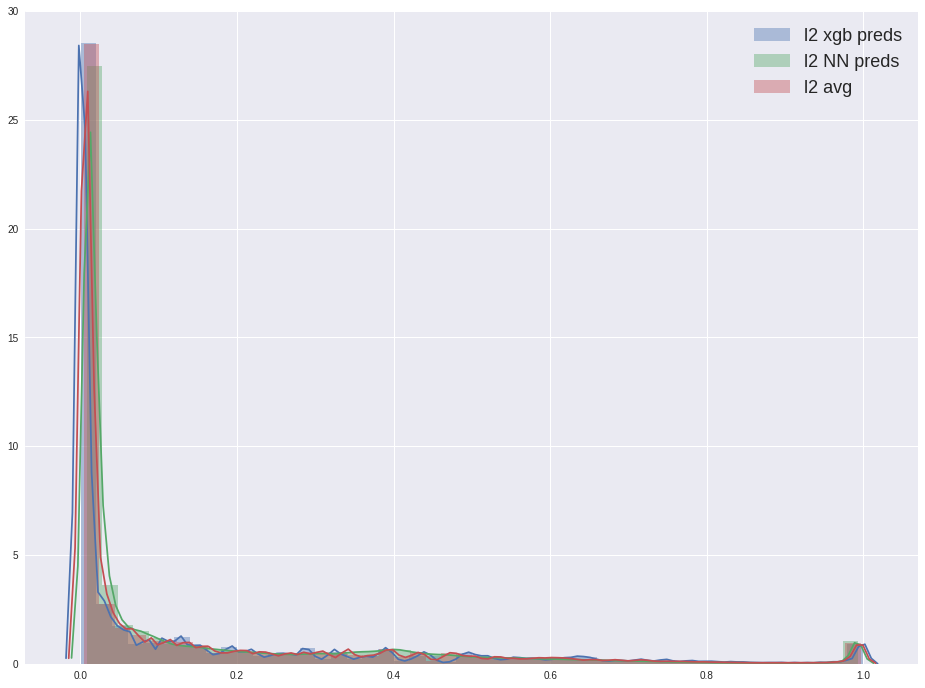

In [149]:
sns.distplot(xgb_stacked_preds_raw,label='l2 xgb preds'),
sns.distplot(NN_stacked_preds_raw,label='l2 NN preds'),
sns.distplot(np.mean([xgb_stacked_preds_raw,NN_stacked_preds_raw],axis=0),label='l2 avg')

plt.legend(loc='upper right', prop={'size': 18})


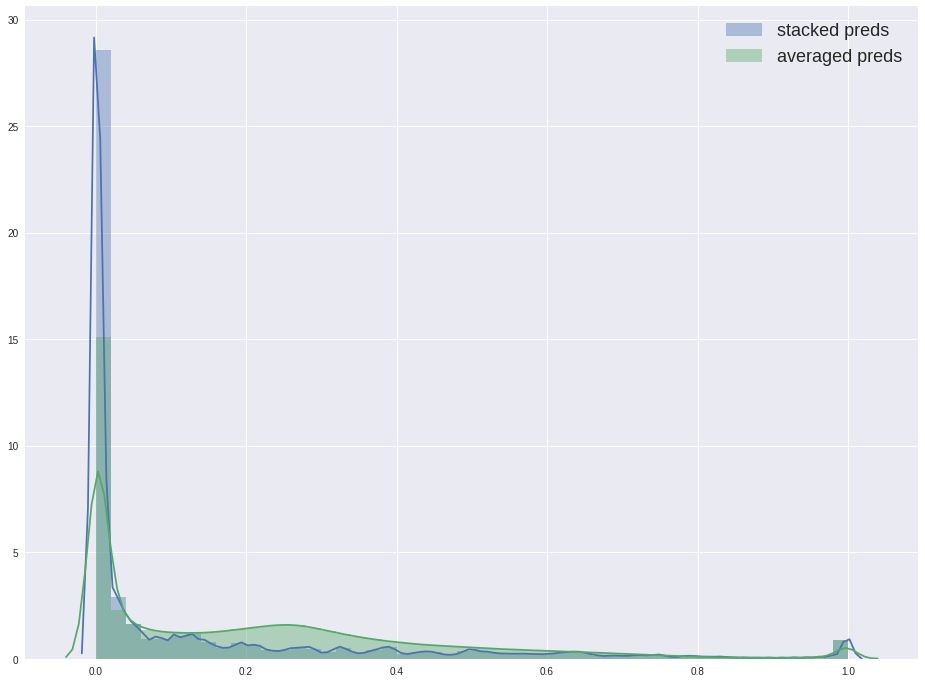

In [87]:
sns.distplot(preds_avg,label='stacked preds'),sns.distplot((xgb_test_preds+NN_test_preds)/2.,label='averaged preds')
plt.legend(loc='upper right', prop={'size': 18})
